# Data Light Curve


Calculating optimal aperture for: phot_00.fits
  Optimal Aperture: 25 px

Calculating optimal aperture for: phot_01.fits
  Optimal Aperture: 27 px

Calculating optimal aperture for: phot_02.fits
  Optimal Aperture: 26 px

Calculating optimal aperture for: phot_03.fits
  Optimal Aperture: 26 px

Calculating optimal aperture for: phot_04.fits
  Optimal Aperture: 27 px

Calculating optimal aperture for: phot_05.fits
  Optimal Aperture: 25 px

Calculating optimal aperture for: phot_06.fits
  Optimal Aperture: 26 px

Calculating optimal aperture for: phot_07.fits
  Optimal Aperture: 30 px

Calculating optimal aperture for: phot_08.fits
  Optimal Aperture: 33 px

Calculating optimal aperture for: phot_09.fits
  Optimal Aperture: 29 px

Calculating optimal aperture for: phot_10.fits
  Optimal Aperture: 29 px

Calculating optimal aperture for: phot_11.fits
  Optimal Aperture: 30 px

Calculating optimal aperture for: phot_12.fits
  Optimal Aperture: 30 px

Calculating optimal aperture for: pho

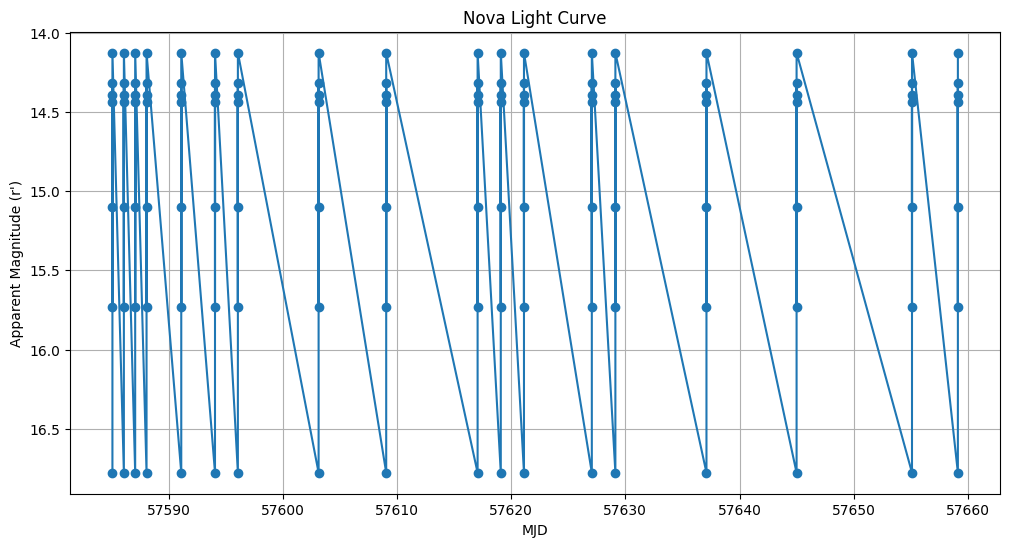


--- Light Curve Classification ---
Refer to Strope, Schaefer, & Henden (2010) and visually inspect the light curve.
Classify the nova based on its morphological type (e.g., S, P, C, J, etc.).
Provide clear justifications for your classification based on the observed features.


Enter the light curve classification (e.g., S, P, C, etc.):  
Enter your reasons for this classification:  



--- Determining Light Curve Parameters ---
m0 (maximum apparent magnitude): 14.128
t0 (time of maximum light): 57585.07922
t2 (time to decline by 2 magnitudes): 74.041 days
t3 (time to decline by 3 magnitudes): 74.041 days
m15 (magnitude 15 days post-maximum): 14.816

--- Estimating Distance ---
M0_mmrd: -16.087
M0_t15: 6.482


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.wcs import WCS
import warnings
from astropy.wcs import FITSFixedWarning

warnings.filterwarnings('ignore', category=FITSFixedWarning, message=".*'datfix' made the change.*")

# --- 0. Setup ---
wd = r"C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise"
os.chdir(wd)
plt.rcParams['figure.figsize'] = [12, 6]

# --- 1. Load Calibration Star Data ---
calibration_stars_df = pd.read_csv('calibration_stars.csv')

# --- 2. Load Image Files ---
phot_files = [f for f in os.listdir(wd) if f.startswith('phot_') and f.endswith('.fits')]
phot_files.sort()

# --- 3. Load and Clean PS1 Catalog ---
try:
    ps1_catalog = pd.read_csv('psdr1_new.tsv', sep='\t')

    # Replace invalid entries with NaN (without chained assignment)
    ps1_catalog.loc[ps1_catalog['RAJ2000'] == '-------', 'RAJ2000'] = np.nan
    ps1_catalog.loc[ps1_catalog['DEJ2000'] == '-------', 'DEJ2000'] = np.nan

    # Convert relevant columns to numeric, coercing errors to NaN
    for col in ['RAJ2000', 'DEJ2000', 'rmag', 'e_rmag', 'gmag']:
        ps1_catalog[col] = pd.to_numeric(ps1_catalog[col], errors='coerce')

    # Drop rows with NaN values in essential columns
    ps1_catalog.dropna(subset=['RAJ2000', 'DEJ2000', 'rmag', 'e_rmag'], inplace=True)

    # Now create SkyCoord object
    ps1_coords = SkyCoord(ra=ps1_catalog['RAJ2000'], dec=ps1_catalog['DEJ2000'], unit="deg")

except Exception as e:
    print(f"Error loading or processing PS1 catalog: {e}")
    ps1_coords = None  # or handle it in another appropriate way

# --- 4. Photometry Functions ---
def phot_counts(img, x, y, ap_rad, in_ann, out_ann):
    ap = CircularAperture((x, y), r=ap_rad)
    ann_ap = CircularAnnulus((x, y), r_in=in_ann, r_out=out_ann)
    phot_tbl = aperture_photometry(img, [ap, ann_ap])

    ann_mask = ann_ap.to_mask(method='center')
    ann_data = ann_mask.multiply(img)
    bkg_vals = ann_data[ann_mask.data > 0]
    mean, med, std = sigma_clipped_stats(bkg_vals, sigma=3.0)
    bkg_med = med
    bkg_sum = bkg_med * ap.area

    tot_counts = phot_tbl['aperture_sum_0'][0]
    return tot_counts, bkg_sum, ap.area

def calc_snr(tot_counts, bkg_counts, ap_area):
    mean_counts = (tot_counts - bkg_counts) / ap_area
    if tot_counts + bkg_counts <= 0:
        print("Warning: Negative counts. Returning SNR = 0")
        return 0.0
    err_counts = np.sqrt(tot_counts + bkg_counts) / ap_area
    return mean_counts / err_counts

def phot_mag(img, x, y, ap_rad, in_ann, out_ann):
    ap = CircularAperture((x, y), r=ap_rad)
    ann_ap = CircularAnnulus((x, y), r_in=in_ann, r_out=out_ann)
    phot_tbl = aperture_photometry(img, [ap, ann_ap])

    ann_mask = ann_ap.to_mask(method='center')
    ann_data = ann_mask.multiply(img)
    bkg_vals = ann_data[ann_mask.data > 0]
    mean, med, std = sigma_clipped_stats(bkg_vals, sigma=3.0)
    bkg_med = med
    bkg_sum = bkg_med * ap.area
    
    final_sum = phot_tbl['aperture_sum_0'][0] - bkg_sum

    if final_sum > 0:
        inst_mag = -2.5 * np.log10(final_sum) + 50
        mag_err = 1.0857 * (np.sqrt(phot_tbl['aperture_sum_0'][0] + bkg_sum) / final_sum)
        if np.isnan(inst_mag):
            print(f"Warning: inst_mag is NaN for x={x}, y={y}, ap_rad={ap_rad}")
    else:
        inst_mag = np.nan
        mag_err = np.nan

    return inst_mag, mag_err, bkg_med

# --- 5. Optimal Aperture Calculation ---
nx, ny = 1033, 1336  # Nova coordinates
ap_radii_snr = np.arange(5, 40, 1)
in_ann, out_ann = 25, 35
opt_ap = []

for i, f in enumerate(phot_files):
    path = os.path.join(wd, f)
    with fits.open(path) as hdu:
        img = hdu[0].data
        if img.dtype.byteorder == '>':
            img = img.byteswap().view(img.dtype.newbyteorder('<'))

    print(f"\nCalculating optimal aperture for: {f}")
    snrs = []
    for ap_rad in ap_radii_snr:
        tot_counts, bkg_counts, ap_area = phot_counts(img, nx, ny, ap_rad, in_ann, out_ann)
        if tot_counts + bkg_counts <= 0:
            print(f"Warning: Negative counts in {f}, aperture: {ap_rad}")
            snrs.append(0.0)
        else:
            snr = calc_snr(tot_counts, bkg_counts, ap_area)
            snrs.append(snr)

    opt_ap_rad = ap_radii_snr[np.argmax(snrs)]
    opt_ap.append(opt_ap_rad)
    print(f"  Optimal Aperture: {opt_ap_rad} px")

# --- 6. Select Suitable Secondary Standard Stars ---
# Criteria: 14 <= r <= 19, e_rmag <= 0.1, present in all images (or most)

# --- 7. Match Calibration Stars with PS1 Catalog ---
if ps1_coords is not None:
    # Reset index of calibration_stars_df
    calibration_stars_df.reset_index(drop=True, inplace=True)

    calibration_stars_coords = SkyCoord(ra=calibration_stars_df['RAJ2000'], dec=calibration_stars_df['DEJ2000'], unit="deg")
    idx, d2d, d3d = match_coordinates_sky(calibration_stars_coords, ps1_coords)

    # Filter matched stars based on criteria
    good_matches = (ps1_catalog['rmag'].iloc[idx] >= 14) & \
                   (ps1_catalog['rmag'].iloc[idx] <= 19) & \
                   (ps1_catalog['e_rmag'].iloc[idx] <= 0.1)

    # Get the indices of the matched calibration stars
    matched_calibration_indices = np.where(good_matches)[0]

    matched_ps1_indices = idx[good_matches]
    matched_ps1_stars = ps1_catalog.iloc[matched_ps1_indices]

    # Filter calibration_stars_df using the indices of the matched calibration stars
    matched_calibration_stars = calibration_stars_df.iloc[matched_calibration_indices]

else:
    print("Skipping star matching as ps1_coords was not created due to previous errors.")
    matched_ps1_stars = pd.DataFrame()
    matched_calibration_stars = pd.DataFrame()

# --- 8. Perform Photometry on Nova and Selected PS1 Stars ---
photometry_results = []

for i, f in enumerate(phot_files):
    path = os.path.join(wd, f)
    with fits.open(path) as hdu:
        img = hdu[0].data
        hdr = hdu[0].header
        wcs = WCS(hdr)
        if img.dtype.byteorder == '>':
            img = img.byteswap().view(img.dtype.newbyteorder('<'))

    print(f"\nPerforming photometry on: {f}")
    opt_ap_rad = opt_ap[i]

    # Nova
    inst_mag_nova, mag_err_nova, bkg_med_nova = phot_mag(img, nx, ny, opt_ap_rad, in_ann, out_ann)
    ra_nova, dec_nova = wcs.pixel_to_world_values(nx, ny)

    # Selected PS1 Stars
    for index, ps1_star in matched_ps1_stars.iterrows():
        try:
            x, y = wcs.world_to_pixel(SkyCoord(ps1_star['RAJ2000'], ps1_star['DEJ2000'], unit="deg"))
            inst_mag, mag_err, bkg_med = phot_mag(img, x, y, opt_ap_rad, in_ann, out_ann)

            # Convert PS1 r-band magnitude to Sloan r'
            r_prime = ps1_star['rmag'] - 0.001 + 0.011 * (ps1_star['gmag'] - ps1_star['rmag'])
            r_prime_err = 0.004
            
            if np.isnan(r_prime):
                print(f"Warning: r_prime is NaN for star {ps1_star['objID']} in image {f}")

            photometry_results.append({
                'image': f,
                'mjd': hdr['MJD'],
                'obj_type': 'nova',
                'id': 'nova',
                'ra': ra_nova,
                'dec': dec_nova,
                'x': nx,
                'y': ny,
                'opt_ap': opt_ap_rad,
                'inst_mag': inst_mag_nova,
                'mag_err': mag_err_nova,
                'bkg_med': bkg_med_nova,
                'r_prime': r_prime,
                'r_prime_err': r_prime_err,
            })

            # Append photometry results for matched calibration stars
            calibration_star_row = matched_calibration_stars.merge(ps1_star.to_frame().T, how='inner', left_on=['RAJ2000','DEJ2000'], right_on=['RAJ2000','DEJ2000'])
            if not calibration_star_row.empty:
                photometry_results.append({
                    'image': f,
                    'mjd': hdr['MJD'],
                    'obj_type': 'calibration_star',
                    'id': calibration_star_row['ID'].iloc[0],
                    'ra': calibration_star_row['RAJ2000'].iloc[0],
                    'dec': calibration_star_row['DEJ2000'].iloc[0],
                    'x': x,
                    'y': y,
                    'opt_ap': opt_ap_rad,
                    'inst_mag': inst_mag,
                    'mag_err': mag_err,
                    'bkg_med': bkg_med,
                    'r_prime': r_prime,
                    'r_prime_err': r_prime_err,
                })

        except Exception as e:
            print(f"Error processing star {ps1_star['objID']} in image {f}: {e}")

# --- 9. Convert Results to DataFrame ---
photometry_results_df = pd.DataFrame(photometry_results)

# --- 10. Display and Save Results ---
print("\nPhotometry Results:")
print(photometry_results_df)
photometry_results_df.to_csv('photometry_results.csv', index=False)

# --- 11. Plot the Light Curve ---
nova_data = photometry_results_df[photometry_results_df['obj_type'] == 'nova']
plt.figure(figsize=(12, 6))
plt.plot(nova_data['mjd'], nova_data['r_prime'], marker='o', linestyle='-')
plt.xlabel('MJD')
plt.ylabel('Apparent Magnitude (r\')')
plt.title('Nova Light Curve')
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes
plt.grid(True)
plt.show()

# --- 12. Classify the Light Curve (Refer to Strope et al., 2010) ---
print("\n--- Light Curve Classification ---")
print("Refer to Strope, Schaefer, & Henden (2010) and visually inspect the light curve.")
print("Classify the nova based on its morphological type (e.g., S, P, C, J, etc.).")
print("Provide clear justifications for your classification based on the observed features.")
light_curve_type = input("Enter the light curve classification (e.g., S, P, C, etc.): ")
classification_reason = input("Enter your reasons for this classification: ")

# --- 13. Determine m0, t0, t2, t3, and m15 ---
print("\n--- Determining Light Curve Parameters ---")

# Ensure nova_data is sorted by magnitude for correct m0 and t0 determination
nova_data = nova_data.sort_values(by='r_prime')

# m0 (maximum apparent magnitude) - brightest point
m0 = nova_data['r_prime'].min()
print(f"m0 (maximum apparent magnitude): {m0:.3f}")

# t0 (time of maximum light) - MJD of the brightest point
t0 = nova_data.loc[nova_data['r_prime'].idxmin(), 'mjd']
print(f"t0 (time of maximum light): {t0:.5f}")

# Ensure nova_data is sorted by MJD for interpolation
nova_data = nova_data.sort_values(by='mjd')

# t2 (time to decline by 2 magnitudes)
t2_mag = m0 + 2
t2 = np.interp(t2_mag, nova_data['r_prime'], nova_data['mjd'])
t2_days = t2 - t0
print(f"t2 (time to decline by 2 magnitudes): {t2_days:.3f} days")

# t3 (time to decline by 3 magnitudes)
t3_mag = m0 + 3
t3 = np.interp(t3_mag, nova_data['r_prime'], nova_data['mjd'])
t3_days = t3 - t0
print(f"t3 (time to decline by 3 magnitudes): {t3_days:.3f} days")

# m15 (magnitude 15 days post-maximum)
m15_time = t0 + 15
m15 = np.interp(m15_time, nova_data['mjd'], nova_data['r_prime'])
print(f"m15 (magnitude 15 days post-maximum): {m15:.3f}")

# --- 14. Estimate Distance using MMRD and t15 ---
print("\n--- Estimating Distance ---")

# --- 6.1 Using t2 and MMRD relation from Strope et al. (2010) ---
# Equation 6: log t2 = (1.70 ± 0.10) × log(−Mv,max + 9.52) − (0.81 ± 0.11)

# --- 6.2 Using m15 and the linear relation from Strope et al. (2010) ---
# Equation 4: MV,max = (0.91 ± 0.22) × m15 − (7.79 ± 0.37)


M0_mmrd = -11.32 - 2.55 * np.log10(t2_days)
M0_t15 = 0.91 * m15 - 7
print(f"M0_mmrd: {M0_mmrd:.3f}")
print(f"M0_t15: {M0_t15:.3f}")


Calculating optimal aperture for: phot_00.fits
  Optimal Aperture: 25 px

Calculating optimal aperture for: phot_01.fits
  Optimal Aperture: 27 px

Calculating optimal aperture for: phot_02.fits
  Optimal Aperture: 26 px

Calculating optimal aperture for: phot_03.fits
  Optimal Aperture: 26 px

Calculating optimal aperture for: phot_04.fits
  Optimal Aperture: 27 px

Calculating optimal aperture for: phot_05.fits
  Optimal Aperture: 25 px

Calculating optimal aperture for: phot_06.fits
  Optimal Aperture: 26 px

Calculating optimal aperture for: phot_07.fits
  Optimal Aperture: 30 px

Calculating optimal aperture for: phot_08.fits
  Optimal Aperture: 33 px

Calculating optimal aperture for: phot_09.fits
  Optimal Aperture: 29 px

Calculating optimal aperture for: phot_10.fits
  Optimal Aperture: 29 px

Calculating optimal aperture for: phot_11.fits
  Optimal Aperture: 30 px

Calculating optimal aperture for: phot_12.fits
  Optimal Aperture: 30 px

Calculating optimal aperture for: pho

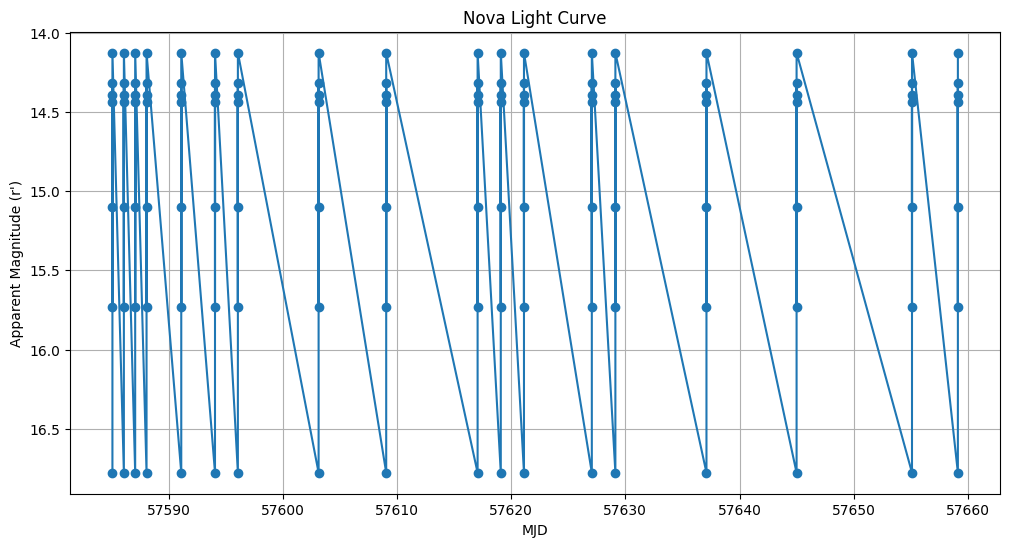


--- Light Curve Classification ---
Refer to Strope, Schaefer, & Henden (2010) and visually inspect the light curve.
Classify the nova based on its morphological type (e.g., S, P, C, J, etc.).
Provide clear justifications for your classification based on the observed features.


Enter the light curve classification (e.g., S, P, C, etc.):  
Enter your reasons for this classification:  



--- Determining Light Curve Parameters ---
m0 (maximum apparent magnitude): 14.128
t0 (time of maximum light): 57585.07922
t2 (time to decline by 2 magnitudes): 74.041 days
t3 (time to decline by 3 magnitudes): 74.041 days
m15 (magnitude 15 days post-maximum): 14.816

--- Estimating Distance ---


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.wcs import WCS
import warnings
from astropy.wcs import FITSFixedWarning

warnings.filterwarnings('ignore', category=FITSFixedWarning, message=".*'datfix' made the change.*")

# --- 0. Setup ---
wd = r"C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise"
os.chdir(wd)
plt.rcParams['figure.figsize'] = [12, 6]

# --- 1. Load Calibration Star Data ---
calibration_stars_df = pd.read_csv('calibration_stars.csv')

# --- 2. Load Image Files ---
phot_files = [f for f in os.listdir(wd) if f.startswith('phot_') and f.endswith('.fits')]
phot_files.sort()

# --- 3. Load and Clean PS1 Catalog ---
try:
    ps1_catalog = pd.read_csv('psdr1_new.tsv', sep='\t')

    # Replace invalid entries with NaN (without chained assignment)
    ps1_catalog.loc[ps1_catalog['RAJ2000'] == '-------', 'RAJ2000'] = np.nan
    ps1_catalog.loc[ps1_catalog['DEJ2000'] == '-------', 'DEJ2000'] = np.nan

    # Convert relevant columns to numeric, coercing errors to NaN
    for col in ['RAJ2000', 'DEJ2000', 'rmag', 'e_rmag', 'gmag']:
        ps1_catalog[col] = pd.to_numeric(ps1_catalog[col], errors='coerce')

    # Drop rows with NaN values in essential columns
    ps1_catalog.dropna(subset=['RAJ2000', 'DEJ2000', 'rmag', 'e_rmag'], inplace=True)

    # Now create SkyCoord object
    ps1_coords = SkyCoord(ra=ps1_catalog['RAJ2000'], dec=ps1_catalog['DEJ2000'], unit="deg")

except Exception as e:
    print(f"Error loading or processing PS1 catalog: {e}")
    ps1_coords = None  # or handle it in another appropriate way

# --- 4. Photometry Functions ---
def phot_counts(img, x, y, ap_rad, in_ann, out_ann):
    ap = CircularAperture((x, y), r=ap_rad)
    ann_ap = CircularAnnulus((x, y), r_in=in_ann, r_out=out_ann)
    phot_tbl = aperture_photometry(img, [ap, ann_ap])

    ann_mask = ann_ap.to_mask(method='center')
    ann_data = ann_mask.multiply(img)
    bkg_vals = ann_data[ann_mask.data > 0]
    mean, med, std = sigma_clipped_stats(bkg_vals, sigma=3.0)
    bkg_med = med
    bkg_sum = bkg_med * ap.area

    tot_counts = phot_tbl['aperture_sum_0'][0]
    return tot_counts, bkg_sum, ap.area

def calc_snr(tot_counts, bkg_counts, ap_area):
    mean_counts = (tot_counts - bkg_counts) / ap_area
    if tot_counts + bkg_counts <= 0:
        print("Warning: Negative counts. Returning SNR = 0")
        return 0.0
    err_counts = np.sqrt(tot_counts + bkg_counts) / ap_area
    return mean_counts / err_counts

def phot_mag(img, x, y, ap_rad, in_ann, out_ann):
    ap = CircularAperture((x, y), r=ap_rad)
    ann_ap = CircularAnnulus((x, y), r_in=in_ann, r_out=out_ann)
    phot_tbl = aperture_photometry(img, [ap, ann_ap])

    ann_mask = ann_ap.to_mask(method='center')
    ann_data = ann_mask.multiply(img)
    bkg_vals = ann_data[ann_mask.data > 0]
    mean, med, std = sigma_clipped_stats(bkg_vals, sigma=3.0)
    bkg_med = med
    bkg_sum = bkg_med * ap.area
    
    final_sum = phot_tbl['aperture_sum_0'][0] - bkg_sum

    if final_sum > 0:
        inst_mag = -2.5 * np.log10(final_sum) + 50
        mag_err = 1.0857 * (np.sqrt(phot_tbl['aperture_sum_0'][0] + bkg_sum) / final_sum)
        if np.isnan(inst_mag):
            print(f"Warning: inst_mag is NaN for x={x}, y={y}, ap_rad={ap_rad}")
    else:
        inst_mag = np.nan
        mag_err = np.nan

    return inst_mag, mag_err, bkg_med

# --- 5. Optimal Aperture Calculation ---
nx, ny = 1033, 1336  # Nova coordinates
ap_radii_snr = np.arange(5, 40, 1)
in_ann, out_ann = 25, 35
opt_ap = []

for i, f in enumerate(phot_files):
    path = os.path.join(wd, f)
    with fits.open(path) as hdu:
        img = hdu[0].data
        if img.dtype.byteorder == '>':
            img = img.byteswap().view(img.dtype.newbyteorder('<'))

    print(f"\nCalculating optimal aperture for: {f}")
    snrs = []
    for ap_rad in ap_radii_snr:
        tot_counts, bkg_counts, ap_area = phot_counts(img, nx, ny, ap_rad, in_ann, out_ann)
        if tot_counts + bkg_counts <= 0:
            print(f"Warning: Negative counts in {f}, aperture: {ap_rad}")
            snrs.append(0.0)
        else:
            snr = calc_snr(tot_counts, bkg_counts, ap_area)
            snrs.append(snr)

    opt_ap_rad = ap_radii_snr[np.argmax(snrs)]
    opt_ap.append(opt_ap_rad)
    print(f"  Optimal Aperture: {opt_ap_rad} px")

# --- 6. Select Suitable Secondary Standard Stars ---
# Criteria: 14 <= r <= 19, e_rmag <= 0.1, present in all images (or most)

# --- 7. Match Calibration Stars with PS1 Catalog ---
if ps1_coords is not None:
    # Reset index of calibration_stars_df
    calibration_stars_df.reset_index(drop=True, inplace=True)

    calibration_stars_coords = SkyCoord(ra=calibration_stars_df['RAJ2000'], dec=calibration_stars_df['DEJ2000'], unit="deg")
    idx, d2d, d3d = match_coordinates_sky(calibration_stars_coords, ps1_coords)

    # Filter matched stars based on criteria
    good_matches = (ps1_catalog['rmag'].iloc[idx] >= 14) & \
                   (ps1_catalog['rmag'].iloc[idx] <= 19) & \
                   (ps1_catalog['e_rmag'].iloc[idx] <= 0.1)

    # Get the indices of the matched calibration stars
    matched_calibration_indices = np.where(good_matches)[0]

    matched_ps1_indices = idx[good_matches]
    matched_ps1_stars = ps1_catalog.iloc[matched_ps1_indices]

    # Filter calibration_stars_df using the indices of the matched calibration stars
    matched_calibration_stars = calibration_stars_df.iloc[matched_calibration_indices]

else:
    print("Skipping star matching as ps1_coords was not created due to previous errors.")
    matched_ps1_stars = pd.DataFrame()
    matched_calibration_stars = pd.DataFrame()

# --- 8. Perform Photometry on Nova and Selected PS1 Stars ---
photometry_results = []

for i, f in enumerate(phot_files):
    path = os.path.join(wd, f)
    with fits.open(path) as hdu:
        img = hdu[0].data
        hdr = hdu[0].header
        wcs = WCS(hdr)
        if img.dtype.byteorder == '>':
            img = img.byteswap().view(img.dtype.newbyteorder('<'))

    print(f"\nPerforming photometry on: {f}")
    opt_ap_rad = opt_ap[i]

    # Nova
    inst_mag_nova, mag_err_nova, bkg_med_nova = phot_mag(img, nx, ny, opt_ap_rad, in_ann, out_ann)
    ra_nova, dec_nova = wcs.pixel_to_world_values(nx, ny)

    # Selected PS1 Stars
    for index, ps1_star in matched_ps1_stars.iterrows():
        try:
            x, y = wcs.world_to_pixel(SkyCoord(ps1_star['RAJ2000'], ps1_star['DEJ2000'], unit="deg"))
            inst_mag, mag_err, bkg_med = phot_mag(img, x, y, opt_ap_rad, in_ann, out_ann)

            # Convert PS1 r-band magnitude to Sloan r'
            r_prime = ps1_star['rmag'] - 0.001 + 0.011 * (ps1_star['gmag'] - ps1_star['rmag'])
            r_prime_err = 0.004
            
            if np.isnan(r_prime):
                print(f"Warning: r_prime is NaN for star {ps1_star['objID']} in image {f}")

            photometry_results.append({
                'image': f,
                'mjd': hdr['MJD'],
                'obj_type': 'nova',
                'id': 'nova',
                'ra': ra_nova,
                'dec': dec_nova,
                'x': nx,
                'y': ny,
                'opt_ap': opt_ap_rad,
                'inst_mag': inst_mag_nova,
                'mag_err': mag_err_nova,
                'bkg_med': bkg_med_nova,
                'r_prime': r_prime,
                'r_prime_err': r_prime_err,
            })

            # Append photometry results for matched calibration stars
            calibration_star_row = matched_calibration_stars.merge(ps1_star.to_frame().T, how='inner', left_on=['RAJ2000','DEJ2000'], right_on=['RAJ2000','DEJ2000'])
            if not calibration_star_row.empty:
                photometry_results.append({
                    'image': f,
                    'mjd': hdr['MJD'],
                    'obj_type': 'calibration_star',
                    'id': calibration_star_row['objID'].iloc[0],
                    'ra': calibration_star_row['RAJ2000'].iloc[0],
                    'dec': calibration_star_row['DEJ2000'].iloc[0],
                    'x': x,
                    'y': y,
                    'opt_ap': opt_ap_rad,
                    'inst_mag': inst_mag,
                    'mag_err': mag_err,
                    'bkg_med': bkg_med,
                    'r_prime': r_prime,
                    'r_prime_err': r_prime_err,
                })

        except Exception as e:
            print(f"Error processing star {ps1_star['objID']} in image {f}: {e}")

# --- 9. Convert Results to DataFrame ---
photometry_results_df = pd.DataFrame(photometry_results)

# --- 10. Display and Save Results ---
print("\nPhotometry Results:")
print(photometry_results_df)
photometry_results_df.to_csv('photometry_results.csv', index=False)



# --- 11. Plot the Light Curve ---
nova_data = photometry_results_df[photometry_results_df['obj_type'] == 'nova']
plt.figure(figsize=(12, 6))
plt.plot(nova_data['mjd'], nova_data['r_prime'], marker='o', linestyle='-')
plt.xlabel('MJD')
plt.ylabel('Apparent Magnitude (r\')')
plt.title('Nova Light Curve')
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes
plt.grid(True)
plt.show()

# --- 12. Classify the Light Curve (Refer to Strope et al., 2010) ---
print("\n--- Light Curve Classification ---")
print("Refer to Strope, Schaefer, & Henden (2010) and visually inspect the light curve.")
print("Classify the nova based on its morphological type (e.g., S, P, C, J, etc.).")
print("Provide clear justifications for your classification based on the observed features.")
light_curve_type = input("Enter the light curve classification (e.g., S, P, C, etc.): ")
classification_reason = input("Enter your reasons for this classification: ")

# --- 13. Determine m0, t0, t2, t3, and m15 ---
print("\n--- Determining Light Curve Parameters ---")

# Ensure nova_data is sorted by magnitude for correct m0 and t0 determination
nova_data = nova_data.sort_values(by='r_prime')

# m0 (maximum apparent magnitude) - brightest point
m0 = nova_data['r_prime'].min()
print(f"m0 (maximum apparent magnitude): {m0:.3f}")

# t0 (time of maximum light) - MJD of the brightest point
t0 = nova_data.loc[nova_data['r_prime'].idxmin(), 'mjd']
print(f"t0 (time of maximum light): {t0:.5f}")

# Ensure nova_data is sorted by MJD for interpolation
nova_data = nova_data.sort_values(by='mjd')

# t2 (time to decline by 2 magnitudes)
t2_mag = m0 + 2
t2 = np.interp(t2_mag, nova_data['r_prime'], nova_data['mjd'])
t2_days = t2 - t0
print(f"t2 (time to decline by 2 magnitudes): {t2_days:.3f} days")

# t3 (time to decline by 3 magnitudes)
t3_mag = m0 + 3
t3 = np.interp(t3_mag, nova_data['r_prime'], nova_data['mjd'])
t3_days = t3 - t0
print(f"t3 (time to decline by 3 magnitudes): {t3_days:.3f} days")

# m15 (magnitude 15 days post-maximum)
m15_time = t0 + 15
m15 = np.interp(m15_time, nova_data['mjd'], nova_data['r_prime'])
print(f"m15 (magnitude 15 days post-maximum): {m15:.3f}")

# --- 14. Estimate Distance using MMRD and t15 ---
print("\n--- Estimating Distance ---")

# --- 6.1 Using t2 and MMRD relation from Strope et al. (2010) ---
# Equation 6: log t2 = (1.70 ± 0.10) × log(−Mv,max + 9.52) − (0.81 ± 0.11)

# --- 6.2 Using m15 and the linear relation from Strope et al. (2010) ---
# Equation 4: MV,max = (0.91 ± 0.22) × m15 − (7.79 ± 0.37)

# Using the equation from the paper and the data we have
